# Quantum + Classical

In [14]:
using Yao, YaoPlots, Plots
using LinearAlgebra, Statistics, Random, StatsBase, MAT, Printf 
using Flux: batch, Flux 
using MultivariateStats, StatsBase, Statistics 
using Zygote
include("../functions/Function_QCL.jl") ; 

# quantum learning

## Relabeling

In [4]:
num_qubit = 10 ;
depth = 3 ;

mid = Int(round(num_qubit/2)) ;
mid = 1 ;

op0 = put(num_qubit, mid=>0.5*(I2+Z)) ;
op1 = put(num_qubit, mid=>0.5*(I2-Z)) ;

In [5]:
pca_dim = num_qubit ; # choose  principal features

In [6]:
num_train = 1000 ;
num_test = 200 ;

# pca 处理
data1 = matread("../dataset/FashionMNIST_0-9.mat")
x_train_1 = real(data1["x_train"][ :, 1 : num_train ]) ; 
y_train_1 = data1["y_train"][ 1 : num_train, : ] ;
x_test_1 = real(data1["x_test"][ :, 1 : num_test ] ) ;  
y_test_1 = data1["y_test"][ 1 : num_test, : ]  ;

In [7]:
x_all = hcat( x_train_1, x_test_1 ) ;

# PCA 
pca_model = fit(PCA, x_all, maxoutdim = pca_dim) ;
trans_X = MultivariateStats.transform(pca_model, x_all) ;
X_std = std( trans_X, dims = 2 ) ; trans_X = trans_X ./ X_std ;  # normalize

# encoding to Rzz gate
trans_X_1 = zeros(pca_dim-1, size(x_all)[2])

for i in 1 : pca_dim-1
    trans_X_1[i, :] =  4 .* trans_X[i, :] .* trans_X[i+1, :]
end

# two layers of encoding
XX = vcat(trans_X, trans_X_1, trans_X, trans_X_1)

trans_x_train_1 = XX[ :, 1 : num_train] ;
trans_x_test_1 = XX[ :, num_train+1 : end] ;

In [39]:
# matwrite("pca_FashionMNIST_0-9.mat", Dict(
#         "pca_x_train" => trans_X[:, 1:num_train] ,
#         "y_train" => y_train_1,
#         "pca_x_test" => trans_X[:, num_train+1 : num_train+num_test],
#         "y_test" => y_test_1 )
#         )

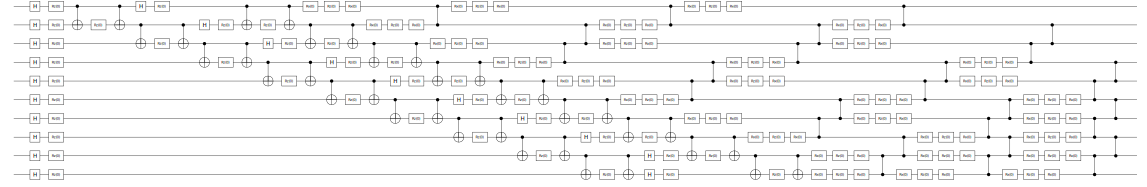

In [8]:
chain_1(nbit::Int64) = chain( H_chain(nbit),  rz_layer(nbit, 1:nbit) ) ;
chain_2(nbit::Int64) = chain( nbit, chain( control(i,i+1=>X), put(i+1 => Rz(0)), control(i,i+1=>X) ) for i in 1 : nbit-1) ;

circuit_encoding(nbit::Int64)  = chain( chain_1(nbit), chain_2(nbit), chain_1(nbit), chain_2(nbit) ) ;
circuit_encoding_2(nbit::Int64)  = chain( rx_layer(nbit, 1:nbit), ent_cx(nbit, 1:nbit) )  ;

circuit_variational(nbit::Int64, depth)  = chain( chain(nbit, params_layer(nbit, 1:nbit), ent_cz(nbit, 1:nbit)) for _ in 1 : depth ) ;
# circuit_variational2(nbit::Int64, depth)  = chain( chain(nbit, params_layer(nbit, 1:nbit), ent_cx(nbit, 1:nbit)) for _ in 1 : depth ) ;

circuit = chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) ) ;
dim = nparameters(circuit) ;
YaoPlots.plot(circuit)

In [41]:
# target_params  = [2* pi *rand() for _ in 1 : dim - (4*pca_dim-2)] ;

In [9]:
target_params = matread("target_params_10.mat")["target_params"] ;

In [10]:
train_cir_1 = [ chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) )   for _ in 1 : num_train] ;

test_cir_1  = [ chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) )  for _ in 1 : num_test] ;

for i in 1 : num_train
    dispatch!( train_cir_1[i], vcat( trans_x_train_1[:, i], target_params ) ) ;
end

for i in 1 : num_test
    dispatch!(test_cir_1[i], vcat( trans_x_test_1[:, i], target_params )) ;
end

In [11]:
q_train = zeros(num_train, 2) ;
for i = 1 : num_train
    res = zero_state(num_qubit) |> train_cir_1[i]
    rdm = density_matrix(res, (mid))
    q_train[i,:] = rdm |> probs
end

y_train_1_re = zeros(num_train, 2) ;

for i in 1 : num_train
    if q_train[i, 1] < 0.5
        y_train_1_re[ i, : ] = [0 , 1]
    else
        y_train_1_re[ i, : ] = [1 , 0]
    end
end

In [12]:
q_test = zeros(num_test, 2) ;

for i = 1 : num_test
    res = zero_state(num_qubit) |> test_cir_1[i]
    rdm = density_matrix(copy(res), (mid))
    q_test[i, :] = rdm |> probs
end

y_test_1_re = zeros(num_test, 2) ;

for i in 1 : num_test
    if q_test[i, 1] < 0.5
        y_test_1_re[ i, : ] = [0 , 1]
    else
        y_test_1_re[ i, : ] = [1 , 0]
    end
end

In [13]:
@show  sum( abs(q_train[i,1] - q_train[i,2]) >=0.2 for i in 1:num_train )
@show  sum( (q_train[i,1] - q_train[i,2]) >=0.2 for i in 1:num_train )
@show  sum( (q_train[i,1] - q_train[i,2]) < -0.2 for i in 1:num_train )
@show  sum( abs(q_test[i,1] - q_test[i,2]) >=0.2 for i in 1:num_test )
@show  sum( (q_test[i,1] - q_test[i,2]) >=0.2 for i in 1:num_test )
@show  sum( (q_test[i,1] - q_test[i,2]) < -0.2 for i in 1:num_test ) ;

sum((abs(q_train[i, 1] - q_train[i, 2]) >= 0.2 for i = 1:num_train)) = 582
sum((q_train[i, 1] - q_train[i, 2] >= 0.2 for i = 1:num_train)) = 347
sum((q_train[i, 1] - q_train[i, 2] < -0.2 for i = 1:num_train)) = 235
sum((abs(q_test[i, 1] - q_test[i, 2]) >= 0.2 for i = 1:num_test)) = 120
sum((q_test[i, 1] - q_test[i, 2] >= 0.2 for i = 1:num_test)) = 69
sum((q_test[i, 1] - q_test[i, 2] < -0.2 for i = 1:num_test)) = 51


In [15]:
index_test = [i for i in 1:num_test if abs(q_test[i, 1] - q_test[i, 2]) >= 0.2] ;
index_train = [i for i in 1:num_train if abs(q_train[i, 1] - q_train[i, 2]) >= 0.2]  ;

num_train_re = length(index_train) ;  num_test_re = length(index_test) ;

In [16]:
# selection
se_y_test_1_re = y_test_1_re[index_test, :]  ;
se_y_train_1_re = y_train_1_re[index_train, :] ;

se_y_train_1 = y_train_1[index_train, :] ;
se_y_test_1 = y_test_1[index_test, :] ;

# select the data with <Z> > 0.1 as the dataset
quantum_trans_x_train_1 = trans_x_train_1[:, index_train] ;
quantum_trans_x_test_1 = trans_x_test_1[:, index_test] ;

classical_x_train_1 = quantum_trans_x_train_1[1 : pca_dim , :]
classical_x_test_1 = quantum_trans_x_test_1[1 : pca_dim , :] ;

In [17]:
# sum( se_y_test_1[i, ] == se_y_test_1_re[i, ] for i in 1 : num_test_re )

In [18]:
sum(se_y_train_1[i, ] == se_y_train_1_re[i, ] for i in 1 : num_train_re )

284

## quantum learning

In [334]:
ini_params  = [ 2*pi * rand() for _ in 1 : dim-(4*pca_dim-2)] ;

In [335]:
re_train_cir_1 = [ chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) )   for _ in 1 : num_train_re] ;

re_test_cir_1  = [ chain( circuit_encoding(num_qubit), circuit_variational(num_qubit, depth) )  for _ in 1 : num_test_re] ;


for i in 1 : num_train_re
    dispatch!( re_train_cir_1[i], vcat( quantum_trans_x_train_1[:, i], ini_params ) ) ;
end

for i in 1 : num_test_re
    dispatch!(re_test_cir_1[i], vcat( quantum_trans_x_test_1[:, i], ini_params )) ;
end

In [336]:
train_acc, train_loss = acc_loss_evaluation(num_qubit, re_train_cir_1, se_y_train_1_re, num_train_re, mid)
test_acc, test_loss = acc_loss_evaluation(num_qubit, re_test_cir_1, se_y_test_1_re, num_test_re, mid)

(0.55, 0.9077592969939263)

In [161]:
# matwrite("initial_params.mat", Dict(
#         "initial_params" => ini_params  )
#         )

In [162]:
# ini_params

In [163]:
# hyper-parameters
batch_size = 25       # batch size
lr1 = 0.05          # learning rate
niters = 30      # number of iterations
optim1 = Flux.NADAM(lr1) # Adam optimizer  

# record the training history
history_loss_train_1nd_1 = Float64[]
history_acc_train_1nd_1 = Float64[]
history_loss_test_1nd_1 = Float64[] ;
history_acc_test_1nd_1 = Float64[] ;

grad_1_history = [] ; 

para_1_history = [] ;
distance_history = Float64[] ;

para_1 = copy(ini_params) ;

In [ ]:
for k in 1 : niters
    # calculate the accuracy & loss for the training & test set
#     acc_train_1nd_1, loss_train_1nd_1 = acc_loss_evaluation(num_qubit, re_train_cir_1, se_y_train_1_re, num_train_re, mid)   ###
    acc_test_1nd_1, loss_test_1nd_1 = acc_loss_evaluation(num_qubit, re_test_cir_1, se_y_test_1_re, num_test_re, mid)       ###
    
#     push!(history_loss_train_1nd_1, loss_train_1nd_1 ) ;   push!(history_acc_train_1nd_1, acc_train_1nd_1) ;
    push!(history_loss_test_1nd_1, loss_test_1nd_1) ;   push!(history_acc_test_1nd_1, acc_test_1nd_1)
    push!(para_1_history, para_1)
    push!(distance_history, norm(para_1 - ini_params ) )
    
#     @printf("\nStep=%d, train_loss=%.3f, train_acc=%.3f\n", k, loss_train_1nd_1, acc_train_1nd_1)
    @printf("\nStep=%d, test_loss=%.3f, test_acc=%.3f\n", k, loss_test_1nd_1, acc_test_1nd_1)
    
    # at each training epoch, randomly choose a batch of samples from the training set
    batch_index = randperm(num_train_re)[1 : batch_size]
    batch_cir = re_train_cir_1[batch_index]
    y_batch = se_y_train_1_re[batch_index,:]     #####

    q_ = zeros(batch_size, 2) ;
    for i = 1 : batch_size
        q_[i, :] = density_matrix(zero_state(num_qubit) |> batch_cir[i], (mid)) |> Yao.probs
    end
    
    # calculate the gradients 
    Arr = Array{Float64}(zeros(batch_size, dim))
    for i in 1 : batch_size
        Arr[i, :] = expect'(op0, zero_state(num_qubit)=>batch_cir[i])[2]
    end
    
    C = [Arr, -Arr]
    
    grads = collect(mean([-sum([y_batch[i,j]*((1 ./ q_)[i,j])*batch(C)[i,:,j] for j in 1:2]) for i = 1 : batch_size]) )

    push!(grad_1_history, copy(grads[4*pca_dim-1 : dim])) 
    
    # update the parameters
    para_1 = Flux.Optimise.update!(optim1, copy(para_1), grads[4*pca_dim-1 : dim]) ;
    
    # update the parameters
    for i in 1 : num_train_re
        dispatch!(re_train_cir_1[i], vcat( quantum_trans_x_train_1[:, i], para_1  )  )
    end
    for i in 1 : num_test_re
        dispatch!(re_test_cir_1[i],  vcat( quantum_trans_x_test_1[:, i], para_1  )  )
    end
    
    if ( acc_test_1nd_1 >= 0.97  &&  loss_test_1nd_1 <= 0.53 && k >= 12) || (k >= 20)
        break
    end
    
end

In [ ]:
Plots.plot(history_acc_test_1nd_1, label="")

## learning the 2nd classical task

In [55]:
acc_loss_evaluation(num_qubit, re_train_cir_1, se_y_train_1_re, num_train_re, mid)

(0.9243986254295533, 0.33034581761208437)

In [165]:
# fisher information
fim1 = fisher(num_train_re, re_train_cir_1, se_y_train_1_re) ;
fim1 = fim1[4*pca_dim-1 : dim] ;

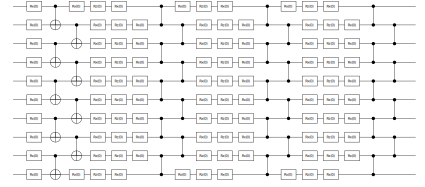

In [27]:
circuit_2 = chain( circuit_encoding_2(num_qubit), circuit_variational(num_qubit, depth) ) ;
dim_2 = nparameters(circuit_2) ;
YaoPlots.plot(circuit_2)

In [51]:
num_train_2 = 500 ;
num_test_2 = 100 ;

# pca 处理
data2 = matread("../dataset/MedNIST_hand_breast_wk.mat")

x_train_2 = real(data2["x_train"][ :, 1 : num_train_2 ]) ; 
y_train_2 = data2["y_train"][ 1 : num_train_2, : ] ;
x_test_2 = real(data2["x_test"][ :, 1 : num_test_2 ] ) ;  
y_test_2 = data2["y_test"][ 1 : num_test_2, : ]  ;

In [52]:
x_all_2 = hcat( x_train_2, x_test_2 ) ;

# PCA 
pca_model_2 = fit(PCA, x_all_2, maxoutdim = pca_dim) ;
trans_X_ = MultivariateStats.transform(pca_model_2, x_all_2) ;
X_std_2 = std( trans_X_, dims = 2 ) ; trans_X_ = trans_X_ ./ X_std_2 ;  # normalize

x_train_2 =  trans_X_[:, 1 : num_train_2]
x_test_2 =  trans_X_[:, num_train_2+1 : end] ;

In [53]:
# #
# matwrite("pca_MedNIST_hand_breast.mat", Dict(
#         "pca_x_train" => x_train_2,
#         "y_train" => y_train_2,
#         "pca_x_test" => x_test_2,
#         "y_test" => y_test_2 )
#         )

In [54]:
history_acc_train_2nd_2 = Float64[] ;   history_acc_test_2nd_2 = Float64[] ;
history_loss_train_2nd_2 = Float64[] ;   history_loss_test_2nd_2 = Float64[] ;

history_acc_test_2nd_1 = Float64[] ;   history_loss_test_2nd_1 = Float64[] ;

grad_2_history = [] ;

para_2_history = [] ;
distance_history_2 = Float64[] ;

In [170]:
para_2 = copy(para_1_history[end])  ;

In [62]:
# YaoPlots.plot(train_cir_2[1])

In [171]:
train_cir_2 = [chain(circuit_encoding_2(num_qubit), circuit_variational(num_qubit, depth) ) for _ in 1 : num_train_2]
test_cir_2 = [chain(circuit_encoding_2(num_qubit), circuit_variational(num_qubit, depth) ) for _ in 1 : num_test_2];

for i in 1 : num_train_2
    dispatch!(train_cir_2[i], vcat( x_train_2[:, i], para_2 ) )
end
for i in 1 : num_test_2
    dispatch!(test_cir_2[i], vcat( x_train_2[:, i], para_2 ) )
end

for i in 1 : num_train_re
    dispatch!(re_train_cir_1[i], vcat( quantum_trans_x_train_1[:, i], para_2 ) )
end
for i in 1 : num_test_re
    dispatch!(re_test_cir_1[i], vcat( quantum_trans_x_test_1[:, i], para_2 ) )
end

In [172]:
# hyper-parameters
batch_size = 25       # batch size
lr2 = 0.05        # learning rate
niters = 15          # number of iterations
optim2 = Flux.NADAM(lr2) ;# Adam optimizer  

lambda1 = 30;

In [ ]:
for k in 1 : niters

#     acc_train_2nd_2, loss_train_2nd_2 = acc_loss_evaluation(num_qubit, train_cir_2, y_train_2, num_train_2, mid)
    acc_test_2nd_2, loss_test_2nd_2 = acc_loss_evaluation(num_qubit, test_cir_2, y_test_2, num_test_2, mid)
    acc_test_2nd_1, loss_test_2nd_1 = acc_loss_evaluation(num_qubit, re_test_cir_1, se_y_test_1_re, num_test_re, mid)

#     push!(history_acc_train_2nd_2, acc_train_2nd_2) ;    push!(history_loss_train_2nd_2, loss_train_2nd_2) ;   
    push!(history_acc_test_2nd_2, acc_test_2nd_2) ;    push!(history_loss_test_2nd_2, loss_test_2nd_2) ;   
    
    push!(history_acc_test_2nd_1, acc_test_2nd_1) ;    push!(history_loss_test_2nd_1, loss_test_2nd_1) ;  
    
    push!(para_2_history, para_2) ;     push!(distance_history_2, norm(para_2 - para_1_history[end] )    )  ;
    
    @printf("Step=%d, test_loss=%.3f,test_acc=%.3f\n", k, loss_test_2nd_2, acc_test_2nd_2)
    @printf("task1, loss=%.3f, acc=%.3f\n", loss_test_2nd_1, acc_test_2nd_1)
    
    # at each training epoch, randomly choose a batch of samples from the training set
    batch_index = randperm(num_train_2)[1 : batch_size] 
    batch_cir_2 = train_cir_2[batch_index]
    y_batch_2 = y_train_2[batch_index, : ]

    q_ = zeros(batch_size, 2);
    for i = 1 : batch_size
        q_[i, :] = density_matrix(zero_state(num_qubit) |> batch_cir_2[i], (mid)) |> Yao.probs
    end
    
    # calculate the gradients w.r.t. the cross-entropy loss function
    Arr = Array{Float64}(zeros(batch_size, nparameters(batch_cir_2[1])))
    for i in 1 : batch_size
        Arr[i, :] = expect'(op0, zero_state(num_qubit)=>batch_cir_2[i])[2]
    end
    
    C = [Arr, -Arr]
    
    grads = collect(mean([-sum([y_batch_2[i,j]*((1 ./ q_)[i,j])*batch(C)[i,:,j] for j in 1 : 2]) for i = 1 : batch_size]))
    grads = grads[pca_dim+1 : end] ;
    
    push!(grad_2_history, copy(grads) )
  
    grads = grads + lambda1 * fim1 .* (para_2 -para_1_history[end])
    
    # update the parameters
    para_2 = Flux.Optimise.update!(optim2, copy(para_2), grads) ;
    
    # update the parameters
    for i in 1 : num_train_2
        dispatch!(train_cir_2[i], vcat( x_train_2[:, i], para_2 ) )
    end
    for i in 1 : num_test_2
        dispatch!(test_cir_2[i], vcat( x_test_2[:, i], para_2 ) )
    end    
    
    for i in 1 : num_test_re
        dispatch!(re_test_cir_1[i], vcat( quantum_trans_x_test_1[:, i], para_2 ))
    end       
    
#     if  (acc_test_2nd_2 >= 0.96 && loss_test_2nd_2 <= 0.6 && k >= 10) || (k >= 20)
#         break
#     end
    
end

## plot and save the data

In [174]:
q_acc_task1 = vcat(history_acc_test_1nd_1, history_acc_test_2nd_1) ;
q_acc_task2 = vcat(history_acc_test_2nd_2) ;
q_length_1 = length(history_acc_test_1nd_1) ;
q_length_2 = length(history_acc_test_2nd_1) ;
q_length_ = [q_length_1, q_length_2] ;

q_loss_task1 = vcat(history_loss_test_1nd_1, history_loss_test_2nd_1) ;
q_loss_task2 = vcat(history_loss_test_2nd_2) ;

In [ ]:
##
# matwrite("../data/advantage/quantum_learning1.mat", Dict(
#         "q_acc_task1" => q_acc_task1,
#         "q_acc_task2" => q_acc_task2,
#         "q_length_" => q_length_,
#         "q_loss_task1" => q_loss_task1, 
#          "q_loss_task2" => q_loss_task2  )
#         )

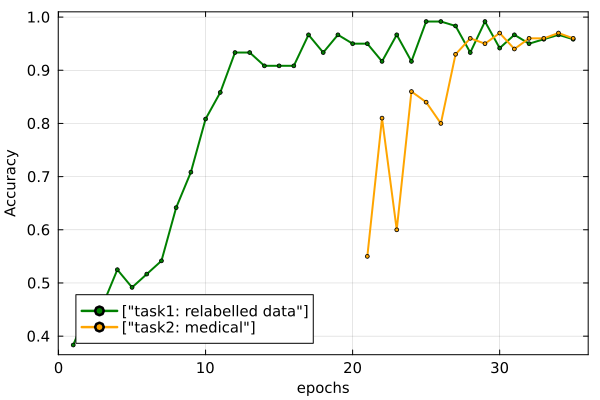

In [175]:
Plots.plot(q_acc_task1, color= :green, label = ["task1: relabelled data"], marker=:o, markersize = 2, lw=2, 
       legend = :bottomright, ylabel="Accuracy", xlabel="epochs", left = "2cm") 
# Plots.plot!(acc_test_history_2, label="accuracy_test_time_of_flight",legend = :bottomright) 
Plots.plot!(q_length_[1]+1 : sum(q_length_), q_acc_task2, color= :orange, marker=:o, markersize = 2, 
        label = ["task2: medical"], lw=2, legend = :bottomleft) 
# p = Plots.twinx() ;
# Plots.plot!(p, q_loss_task1, color= :green, label = ["task1: relabelled data"], marker=:star, markersize = 2, lw=2, size=(6*130, 4*130), 
#                 legend=:none, ylabel="Loss") 
# Plots.plot!(p, q_length_[1]+1 : sum(q_length_), q_loss_task2, color= :orange, marker=:star,  markersize = 2, 
#         label = ["task2: fashionmnist_17"], lw=2, legend=:none, size=(6*100, 4*100) )

fs = 10 ;
Plots.plot!( xtickfontsize = fs, ytickfontsize= fs, xguidefontsize=fs, yguidefontsize=fs , 
                legendfontsize= fs, titlefontsize = fs, legendfont=font(8), framestyle=:box  ) 

# title!("10 qubits - learning two tasks sequantially with the EWC method")

# classical FFNN

In [178]:
# build the model
input_size = size(classical_x_train_1, 1)
output_size = 1
hidden_size = 20 ;

model_1 = Flux.Chain(
    Flux.Dense(input_size, hidden_size, Flux.σ; init = Flux.randn ),
    Flux.Dense(hidden_size, output_size, Flux.σ; init = Flux.randn ),
)  |> Flux.f64

total_params = sum(length, Flux.params(model_1)) ;

@show model_1

model_1 = Chain(Dense(10 => 20, σ), Dense(20 => 1, σ))


Chain(
  Dense(10 => 20, σ),                   # 220 parameters
  Dense(20 => 1, σ),                    # 21 parameters
)                   # Total: 4 arrays, 241 parameters, 2.133 KiB.

In [179]:
ps = Flux.params(model_1)

Params([[-0.614534636979668 0.3938328343935289 … 1.074302848811926 -0.06456353380977647; -0.7734744030582508 -0.3097581685407674 … -2.5569818809456404 -0.10995234907224634; … ; 1.550114328711327 -1.026104006601778 … 0.4296498420511733 -0.42454604298153154; 1.2034402366533257 1.279588629237274 … -0.0011941475660938023 -0.4214418428199342], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.10166798027109603 3.4672792279713094 … -1.0480409253062026 -0.15108263568870595], [0.0]])

In [180]:
# loss function
loss(x, y) = Flux.crossentropy(vcat(model_1(x ), 1 .- model_1(x )) , y)

function acc(x, y)
    y_pred = [ t[1] for t in argmax( vcat(model_1(x), 1 .- model_1(x)),  dims =1 ) ]
    y_true = [ t[1] for t in argmax( y,  dims =1 ) ] ;

    return sum(y_pred .== y_true) / size(x, 2)
end

acc (generic function with 1 method)

In [181]:
c_history_loss_train_1nd_1 = Float64[]
c_history_acc_train_1nd_1 = Float64[]
c_history_loss_test_1nd_1 = Float64[] ;
c_history_acc_test_1nd_1 = Float64[] ;

c_para_1_history = [] ;

## learning the 1st task (relabeled data)

In [182]:
# relabelled data
lr = 0.05
opt = Flux.ADAM(lr)
epochs = 20

data_batch = Flux.Data.DataLoader((classical_x_train_1, se_y_train_1_re'), batchsize = 25, shuffle=true ) 

for k in 1 : epochs
    
#     loss_train_1nd_1 = loss(classical_x_train_1, se_y_train_1_re') ;  acc_train_1nd_1 = acc(classical_x_train_1, se_y_train_1_re')
    loss_test_1nd_1 = loss(classical_x_test_1, se_y_test_1_re') ;   acc_test_1nd_1 = acc(classical_x_test_1, se_y_test_1_re')
    push!( c_para_1_history, deepcopy(ps))
        
#     print(ps); print("\n")
#     push!(c_history_loss_train_1nd_1, loss_train_1nd_1 ) ;   push!(c_history_acc_train_1nd_1, acc_train_1nd_1) 
    push!(c_history_loss_test_1nd_1, loss_test_1nd_1) ;   push!(c_history_acc_test_1nd_1, acc_test_1nd_1)
    
#     @printf("\nStep=%d, train_loss=%.3f, train_acc=%.3f\n", k, loss_train_1nd_1, acc_train_1nd_1)
    @printf("\nStep=%d, test_loss=%.3f, test_acc=%.3f\n", k, loss_test_1nd_1, acc_test_1nd_1)
    
    Flux.train!(loss, ps, data_batch, opt)
end


Step=1, test_loss=0.743, test_acc=0.600

Step=2, test_loss=0.545, test_acc=0.717

Step=3, test_loss=0.467, test_acc=0.775

Step=4, test_loss=0.479, test_acc=0.767

Step=5, test_loss=0.422, test_acc=0.775

Step=6, test_loss=0.391, test_acc=0.833

Step=7, test_loss=0.393, test_acc=0.792

Step=8, test_loss=0.369, test_acc=0.808

Step=9, test_loss=0.338, test_acc=0.850

Step=10, test_loss=0.354, test_acc=0.833

Step=11, test_loss=0.405, test_acc=0.825

Step=12, test_loss=0.349, test_acc=0.825

Step=13, test_loss=0.344, test_acc=0.858

Step=14, test_loss=0.306, test_acc=0.850

Step=15, test_loss=0.289, test_acc=0.858

Step=16, test_loss=0.324, test_acc=0.833

Step=17, test_loss=0.322, test_acc=0.850

Step=18, test_loss=0.308, test_acc=0.858

Step=19, test_loss=0.284, test_acc=0.858

Step=20, test_loss=0.299, test_acc=0.858


In [ ]:
# c_para_1_history[end]
# ps

In [183]:
# fisher_matrix
g = Flux.gradient(() -> loss(classical_x_train_1[:, 1], se_y_train_1_re'[:, 1]), ps)
fisher_t = copy(g) ;
[ fisher_t[ ps[i] ] .= 0 for i in 1 : length(ps) ] ;

for i in 1 : num_train_re
    grads = Flux.gradient(() -> loss(classical_x_train_1[:, i], se_y_train_1_re'[:, i]), ps)
    fisher_ = copy(grads) ;
    [ fisher_[ ps[i] ] = fisher_[ ps[i] ] .^ 2  for i in 1 : length(ps) ] ;

    fisher_t .+= fisher_
end
fisher_t  = fisher_t ./ num_train_re

fisher_m = [];
for n in fisher_t
    push!(fisher_m, n)
end

In [310]:
# fisher_t[ps[2]]

In [33]:
# show(stdout, "text/plain", fisher_m) 

In [63]:
# vcat( [fisher_m[i] for i in 1:4]...)

In [200]:
# fisher_m

## learning the 2nd task

In [343]:
Flux.loadparams!( model_1, c_para_1_history[end] ) ;

In [288]:
# fisher for task 2

g = Flux.gradient(() -> loss(x_train_2[:, 1], y_train_2'[:, 1]), ps)
fisher_t_2 = copy(g) ;
[ fisher_t_2[ ps[i] ] .= 0 for i in 1 : length(ps) ] ;

for i in 1 : num_train_2
    grads = Flux.gradient(() -> loss(x_train_2[:, i], y_train_2'[:, i]), ps)
    fisher_ = copy(grads) ;
    [ fisher_[ ps[i] ] = fisher_[ ps[i] ] .^ 2  for i in 1 : length(ps) ] ;

    fisher_t_2 .+= fisher_
end
fisher_t_2  = fisher_t_2 ./ num_train_2

fisher_m_2 = [];
for n in fisher_t_2
    push!(fisher_m_2, n)
end

In [371]:
# fisher_info_2 = vcat( [vec(fisher_m_2[i]) for i in 1:4] ... ) ;

# fisher_info_1 = vcat( [vec(fisher_m[i]) for i in 1:4] ... ) ;

# index1 = sortperm( fisher_info_1 ) ;

In [344]:
lambda2 = 40;

loss_2(x, y) = Flux.crossentropy(vcat(model_1(x ), 1 .- model_1(x )) , y) 
# + lambda2 * sum(  [  sum( fisher_m[i] .* ( Flux.params(model_1)[i] - c_para_1_history[end][i]) .*  
# ( Flux.params(model_1)[i] - c_para_1_history[end][i]) )  for i in 1 : length( Flux.params(model_1))]    )

loss_2 (generic function with 1 method)

In [345]:
c_history_acc_train_2nd_2 = Float64[] ;   c_history_acc_test_2nd_2 = Float64[] ;
c_history_loss_train_2nd_2 = Float64[] ;   c_history_loss_test_2nd_2 = Float64[] ;

c_history_acc_test_2nd_1 = Float64[] ;   c_history_loss_test_2nd_1 = Float64[] ;
c_history_acc_train_2nd_1 = Float64[] ;   c_history_loss_train_2nd_1 = Float64[] ;

c_para_2_history = [] ;
grad_2_history = [];

In [346]:
# relabelled data
lr2 = 0.05
opt2 = Flux.ADAM(lr2)
epochs = 17

data_batch2 = Flux.Data.DataLoader((x_train_2, y_train_2'), batchsize = 25, shuffle=true ) 

for k in 1 : epochs
   
#     loss_train_2nd_2 = loss_2(x_train_2, y_train_2') ;   acc_train_2nd_2 = acc(x_train_2, y_train_2')
    loss_test_2nd_2 = loss_2(x_test_2, y_test_2') ;   acc_test_2nd_2 = acc(x_test_2, y_test_2')
    
#     loss_train_2nd_1 = loss(classical_x_train_1, se_y_train_1_re') ;  acc_train_2nd_1 = acc(classical_x_train_1, se_y_train_1_re')
    loss_test_2nd_1 = loss(classical_x_test_1, se_y_test_1_re') ;   acc_test_2nd_1 = acc(classical_x_test_1, se_y_test_1_re')
    
#     push!(c_history_acc_train_2nd_2, acc_train_2nd_2) ;    push!(c_history_loss_train_2nd_2, loss_train_2nd_2) ;   
    push!(c_history_acc_test_2nd_2, acc_test_2nd_2) ;    push!(c_history_loss_test_2nd_2, loss_test_2nd_2) ;   
    
#     push!(c_history_acc_train_2nd_1, acc_train_2nd_1) ;    push!(c_history_loss_train_2nd_1, loss_train_2nd_1) ;  
    push!(c_history_acc_test_2nd_1, acc_test_2nd_1) ;    push!(c_history_loss_test_2nd_1, loss_test_2nd_1) ;  
    
    push!(c_para_2_history, deepcopy(ps)) ;  
    
#     @printf("Step=%d, train_loss=%.3f, train_acc=%.3f\n", k, loss_train_2nd_2, acc_train_2nd_2)
    @printf("Step=%d, test_loss=%.3f, test_acc=%.3f\n", k, loss_test_2nd_2, acc_test_2nd_2)
    
#     @printf("train_task1, loss=%.3f, acc=%.3f\n", loss_train_2nd_1, acc_train_2nd_1)
    @printf("task1, loss=%.3f, acc=%.3f\n", loss_test_2nd_1, acc_test_2nd_1)
    
    
    for (x, y) in data_batch2
        grads = Flux.gradient(() -> loss_2(x, y), ps)
        push!( grad_2_history, grads )
        for i in 1 : length(ps)
            grads[ps[i]] = grads[ps[i]] + lambda2 * fisher_t[ps[i]] .* (ps[i]  - c_para_1_history[end][i])
        end
        
        Flux.update!(Flux.Adam(lr2), ps, grads)
        
    end
end

Step=1, test_loss=1.177, test_acc=0.520
task1, loss=0.299, acc=0.858
Step=2, test_loss=0.399, test_acc=0.810
task1, loss=0.420, acc=0.825
Step=3, test_loss=0.350, test_acc=0.850
task1, loss=0.435, acc=0.817
Step=4, test_loss=0.326, test_acc=0.860
task1, loss=0.434, acc=0.800
Step=5, test_loss=0.375, test_acc=0.790
task1, loss=0.418, acc=0.817
Step=6, test_loss=0.415, test_acc=0.820
task1, loss=0.450, acc=0.792
Step=7, test_loss=0.344, test_acc=0.840
task1, loss=0.423, acc=0.800
Step=8, test_loss=0.366, test_acc=0.820
task1, loss=0.430, acc=0.825
Step=9, test_loss=0.385, test_acc=0.830
task1, loss=0.409, acc=0.825
Step=10, test_loss=0.372, test_acc=0.850
task1, loss=0.450, acc=0.800
Step=11, test_loss=0.403, test_acc=0.800
task1, loss=0.429, acc=0.817
Step=12, test_loss=0.418, test_acc=0.810
task1, loss=0.401, acc=0.825
Step=13, test_loss=0.347, test_acc=0.830
task1, loss=0.432, acc=0.800
Step=14, test_loss=0.298, test_acc=0.890
task1, loss=0.467, acc=0.783
Step=15, test_loss=0.283, tes

## plot and save the data

In [311]:
c_acc_task1 = vcat(c_history_acc_test_1nd_1, c_history_acc_test_2nd_1) ;
c_acc_task2 = vcat(c_history_acc_test_2nd_2) ;
c_length_1 = length(c_history_acc_test_1nd_1) ;
c_length_2 = length(c_history_acc_test_2nd_1) ;
c_length_ = [c_length_1, c_length_2] ;

c_loss_task1 = vcat(c_history_loss_test_1nd_1, c_history_loss_test_2nd_1) ;
c_loss_task2 = vcat(c_history_loss_test_2nd_2) ;


train_c_acc_task1 = vcat(c_history_acc_train_1nd_1, c_history_acc_train_2nd_1) ;
train_c_acc_task2 = vcat(c_history_acc_train_2nd_2) ;

In [ ]:
##
matwrite("classical_learning_lambda_40.mat", Dict(
        "c_acc_task1" => c_acc_task1,
        "c_acc_task2" => c_acc_task2,
        "c_length_" => c_length_,
        "c_loss_task1" => c_loss_task1, 
         "c_loss_task2" => c_loss_task2  )
        )

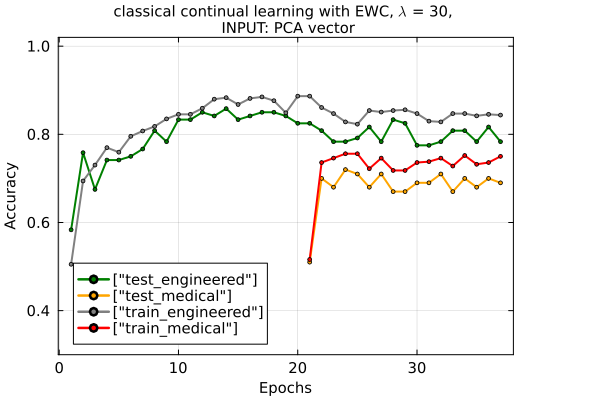

In [312]:
Plots.plot(c_acc_task1, color= :green, label = ["test_engineered"], marker=:o, markersize = 2, lw=2, 
       legend = :bottomright, ylabel="Accuracy", xlabel="epochs", right_margin = 2cm, left_margin = 0.1cm, top_margin = 0.1cm ) 

Plots.plot!(c_length_[1]+1 : sum(c_length_), c_acc_task2, color= :orange, marker=:o, markersize = 2, 
        label = ["test_medical"], lw=2, legend = :bottomleft) 

Plots.plot!(train_c_acc_task1, color= :grey, label = ["train_engineered"], marker=:o, markersize = 2, lw=2, 
       legend = :bottomright, ylabel="Accuracy", xlabel="Epochs", right_margin = 2cm, left_margin = 0.1cm, top_margin = 0.1cm ) 

Plots.plot!(c_length_[1]+1 : sum(c_length_), train_c_acc_task2, color= :red, marker=:o, markersize = 2, 
        label = ["train_medical"], lw=2, legend = :bottomleft) 

ylims!(0.3, 1.02)

fs = 10 ;
Plots.plot!( xtickfontsize = fs, ytickfontsize= fs, xguidefontsize=fs, yguidefontsize=fs , 
                legendfontsize= fs, titlefontsize = fs, legendfont=font(8), framestyle=:box  ) 

title!("classical continual learning with EWC, \$\\lambda\$ = 30, \n INPUT: PCA vector")